# Multi-Task Hierarchical Modeling
In multi-task hierarchical modeling, there is an explicit dependency structure between the tasks. The output of one task may be used as input (or conditioning context) for another.

Example Hierarchies:

  * Predict hatespeech first, then condition directness, target, etc., on that prediction.

  * Predict target, then use it to inform group, because groups are nested under targets.

                 [Transformer]
                      ↓
                 [hate_head]
                      ↓
           [directness | hate]
                      ↓
        [target | directness, hate]
                      ↓
        [group | target, directness, hate]


Reasons we're exploring hierarchical modeling:
- tasks are casually dependent
- the data is imbalanced and need strong signals from simpler tasks

In [1]:
!pip install -q evaluate torchinfo bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.4 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel
import pandas as pd

import numpy as np
from datasets import Dataset
import evaluate
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer
from torchinfo import summary
import torch
from transformers import BertTokenizer, BertForSequenceClassification, BitsAndBytesConfig
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#load dataset
train_df = pd.read_csv('/content/drive/MyDrive/final_project/combined_train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/final_project/combined_test.csv')
val_df = pd.read_csv('/content/drive/MyDrive/final_project/combined_val.csv')

In [6]:
train_df = train_df.dropna(subset=["text_cleaned"])
test_df = test_df.dropna(subset=["text_cleaned"])
val_df = val_df.dropna(subset=["text_cleaned"])

In [7]:
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [8]:
#convert to HuggingFace dataset / format
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
val_dataset = Dataset.from_pandas(val_df)

In [9]:
sentiment_cols = [col for col in train_df.columns if col.startswith('sentiment_')]
sentiment_cols

['sentiment_anger',
 'sentiment_confusion',
 'sentiment_disgust',
 'sentiment_fear',
 'sentiment_indifference',
 'sentiment_normal',
 'sentiment_sadness',
 'sentiment_shock']

In [10]:
# Tokenizer
from transformers import AutoModel, AutoTokenizer

model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [11]:
from torch.utils.data import Dataset

class HierarchicalDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128, sentiment_cols=None):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.sentiment_cols = sentiment_cols or []

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        encoding = self.tokenizer(
            str(row['text_cleaned']),
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        sentiments = torch.tensor(row[self.sentiment_cols].values.astype(float), dtype=torch.float) if self.sentiment_cols else torch.empty(0)

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'hate': torch.tensor(float(row['hatespeech']), dtype=torch.float),
            'directness': torch.tensor(int(row['directness_label']), dtype=torch.long),
            'target': torch.tensor(int(row['target_label']), dtype=torch.long),
            'group': torch.tensor(int(row['group_label']), dtype=torch.long),
            'sentiments': sentiments,
            'language': row['language_encoded']
        }

# Hierarchical Multi-Task Model

In [12]:
import torch.nn as nn

class HierarchicalMultiTaskModel(nn.Module):
    def __init__(self, base_model, hidden_dim=768, num_groups=17, num_targets=4, num_directness=3, sentiment_size=8):
        super().__init__()
        self.encoder = base_model

        self.hate_head = nn.Linear(hidden_dim, 1)
        self.directness_head = nn.Linear(hidden_dim + 1, 3)
        self.target_head = nn.Linear(hidden_dim + 3, 7)
        self.group_head = nn.Linear(hidden_dim + 7, 17)
        self.sentiment_head = nn.Linear(hidden_dim, 8)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # CLS token

        hate_logits = self.hate_head(pooled_output)
        directness_logits = self.directness_head(torch.cat([pooled_output, torch.sigmoid(hate_logits)], dim=1))
        target_logits = self.target_head(torch.cat([pooled_output, torch.softmax(directness_logits, dim=1)], dim=1))
        group_logits = self.group_head(torch.cat([pooled_output, torch.softmax(target_logits, dim=1)], dim=1))
        sentiment_logits = self.sentiment_head(pooled_output)

        return {
            'hate': hate_logits.squeeze(-1),
            'directness': directness_logits,
            'target': target_logits,
            'group': group_logits,
            'sentiments': sentiment_logits
        }


# Loss Function

In [13]:
train_dataset = HierarchicalDataset(train_df, tokenizer, max_len=128, sentiment_cols=sentiment_cols)
val_dataset =HierarchicalDataset(val_df, tokenizer, max_len=128, sentiment_cols=sentiment_cols)
test_dataset = HierarchicalDataset(test_df, tokenizer, max_len=128, sentiment_cols=sentiment_cols)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [14]:
from torch.optim import AdamW
from tqdm import tqdm
# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HierarchicalMultiTaskModel(base_model).to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)


In [15]:
def compute_loss(outputs, labels):
    loss_fn_bce = nn.BCEWithLogitsLoss()
    loss_fn_ce = nn.CrossEntropyLoss()

    hate_loss = loss_fn_bce(outputs['hate'], labels['hate'])
    directness_loss = loss_fn_ce(outputs['directness'], labels['directness'])
    target_loss = loss_fn_ce(outputs['target'], labels['target'])
    group_loss = loss_fn_ce(outputs['group'], labels['group'])
    sentiments_loss = loss_fn_bce(outputs['sentiments'], labels['sentiments'])

    total_loss = hate_loss + directness_loss + target_loss + group_loss + sentiments_loss
    return total_loss


# Evaluate Function

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def evaluate1(model, dataloader):
    model.eval()
    hate_preds, hate_labels = [], []
    dir_preds, dir_labels = [], []
    tgt_preds, tgt_labels = [], []
    grp_preds, grp_labels = [], []
    sent_preds, sent_labels = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Binary hate
            preds = (torch.sigmoid(outputs['hate']) > 0.5).int().cpu()
            labels = batch['hate'].int()
            hate_preds.extend(preds.numpy())
            hate_labels.extend(labels.numpy())

            # Multi-class
            for task in ['directness', 'target', 'group']:
                preds = torch.argmax(outputs[task], dim=1).cpu()
                labels = batch[task]
                if task == 'directness':
                    dir_preds.extend(preds.numpy())
                    dir_labels.extend(labels.numpy())
                elif task == 'target':
                    tgt_preds.extend(preds.numpy())
                    tgt_labels.extend(labels.numpy())
                else:
                    grp_preds.extend(preds.numpy())
                    grp_labels.extend(labels.numpy())

            # Sentiment: multilabel
            sent_out = (torch.sigmoid(outputs['sentiments']) > 0.5).int().cpu()
            sent_lbl = batch['sentiments'].int()
            sent_preds.append(sent_out.numpy())
            sent_labels.append(sent_lbl.numpy())

    # Stack sentiment arrays
    sent_preds = np.vstack(sent_preds)
    sent_labels = np.vstack(sent_labels)

    print("\nHATE (Binary):")
    print("  Accuracy:", accuracy_score(hate_labels, hate_preds))
    print("  Precision (micro):", precision_score(hate_labels, hate_preds, average='micro'))
    print("  Recall (micro):", recall_score(hate_labels, hate_preds, average='micro'))
    print("  F1 Score (micro):", f1_score(hate_labels, hate_preds, average='micro'))

    print("\nDIRECTNESS (Multi-Class):")
    print("  Accuracy:", accuracy_score(dir_labels, dir_preds))
    print("  Precision (micro):", precision_score(dir_labels, dir_preds, average='micro'))
    print("  Recall (micro):", recall_score(dir_labels, dir_preds, average='micro'))
    print("  F1 Score (micro):", f1_score(dir_labels, dir_preds, average='micro'))

    print("\nTARGET (Multi-Class):")
    print("  Accuracy:", accuracy_score(tgt_labels, tgt_preds))
    print("  Precision (micro):", precision_score(tgt_labels, tgt_preds, average='micro'))
    print("  Recall (micro):", recall_score(tgt_labels, tgt_preds, average='micro'))
    print("  F1 Score (micro):", f1_score(tgt_labels, tgt_preds, average='micro'))

    print("\nGROUP (Multi-Class):")
    print("  Accuracy:", accuracy_score(grp_labels, grp_preds))
    print("  Precision (micro):", precision_score(grp_labels, grp_preds, average='micro'))
    print("  Recall (micro):", recall_score(grp_labels, grp_preds, average='micro'))
    print("  F1 Score (micro):", f1_score(grp_labels, grp_preds, average='micro'))

    print("\nSENTIMENTS (Multi-Label, 8 classes):")
    print("  Precision (micro):", precision_score(sent_labels, sent_preds, average='micro'))
    print("  Recall (micro):", recall_score(sent_labels, sent_preds, average='micro'))
    print("  F1 Score (micro):", f1_score(sent_labels, sent_preds, average='micro'))


# Model Training

In [17]:
def train(model, train_loader, val_loader, epochs=3):
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for batch in loop:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            labels = {
                'hate': batch['hate'].to(device),
                'directness': batch['directness'].to(device),
                'target': batch['target'].to(device),
                'group': batch['group'].to(device),
                'sentiments': batch['sentiments'].to(device)
            }

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = compute_loss(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_train_loss = total_loss / len(train_loader)
        print(f"\nEpoch {epoch+1} Training Loss: {avg_train_loss:.4f}")

        #evaluate1(model, val_loader)


In [19]:
train(model, train_loader, val_loader, epochs=3)

Epoch 1/3:   0%|          | 0/480 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 1/3:   0%|          | 1/480 [00:01<10:24,  1.30s/it, loss=5.94]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 1/3:   0%|          | 2/480 [00:02<10:06,  1.27s/it, loss=5.09]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 1/3:   1%|          | 3/480 [00:03<09:58,  1.26s/it, loss=5.39]/u


Epoch 1 Training Loss: 3.1083


Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Evaluating:   2%|▏         | 1/61 [00:00<00:30,  2.00it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Evaluating:   3%|▎         | 2/61 [00:00<00:27,  2.17it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Evaluating:   5%|▍         | 3/61 [00:01<00:26,  2.23it/s]/usr/local/lib/python3.11/dist-pack


HATE (Binary):
  Accuracy: 0.9487179487179487
  Precision (micro): 0.9487179487179487
  Recall (micro): 0.9487179487179487
  F1 Score (micro): 0.9487179487179487

DIRECTNESS (Multi-Class):
  Accuracy: 0.8335897435897436
  Precision (micro): 0.8335897435897436
  Recall (micro): 0.8335897435897436
  F1 Score (micro): 0.8335897435897436

TARGET (Multi-Class):
  Accuracy: 0.7882051282051282
  Precision (micro): 0.7882051282051282
  Recall (micro): 0.7882051282051282
  F1 Score (micro): 0.7882051282051282

GROUP (Multi-Class):
  Accuracy: 0.7066666666666667
  Precision (micro): 0.7066666666666667
  Recall (micro): 0.7066666666666667
  F1 Score (micro): 0.7066666666666667

SENTIMENTS (Multi-Label, 8 classes):
  Precision (micro): 0.734130634774609
  Recall (micro): 0.484149855907781
  F1 Score (micro): 0.5834932821497121


Epoch 2/3:   0%|          | 0/480 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 2/3:   0%|          | 1/480 [00:01<10:12,  1.28s/it, loss=2.36]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 2/3:   0%|          | 2/480 [00:02<10:11,  1.28s/it, loss=1.94]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 2/3:   1%|          | 3/480 [00:03<10:10,  1.28s/it, loss=1.89]/u


Epoch 2 Training Loss: 2.1043


Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Evaluating:   2%|▏         | 1/61 [00:00<00:27,  2.17it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Evaluating:   3%|▎         | 2/61 [00:00<00:26,  2.20it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Evaluating:   5%|▍         | 3/61 [00:01<00:26,  2.18it/s]/usr/local/lib/python3.11/dist-pack


HATE (Binary):
  Accuracy: 0.9520512820512821
  Precision (micro): 0.9520512820512821
  Recall (micro): 0.9520512820512821
  F1 Score (micro): 0.9520512820512821

DIRECTNESS (Multi-Class):
  Accuracy: 0.8441025641025641
  Precision (micro): 0.8441025641025641
  Recall (micro): 0.8441025641025641
  F1 Score (micro): 0.8441025641025641

TARGET (Multi-Class):
  Accuracy: 0.7892307692307692
  Precision (micro): 0.7892307692307692
  Recall (micro): 0.7892307692307692
  F1 Score (micro): 0.7892307692307692

GROUP (Multi-Class):
  Accuracy: 0.7274358974358974
  Precision (micro): 0.7274358974358974
  Recall (micro): 0.7274358974358974
  F1 Score (micro): 0.7274358974358974

SENTIMENTS (Multi-Label, 8 classes):
  Precision (micro): 0.7317127071823204
  Recall (micro): 0.5021993022903078
  F1 Score (micro): 0.5956107213527613


Epoch 3/3:   0%|          | 0/480 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 3/3:   0%|          | 1/480 [00:01<10:36,  1.33s/it, loss=2.29]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 3/3:   0%|          | 2/480 [00:02<10:26,  1.31s/it, loss=1.86]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 3/3:   1%|          | 3/480 [00:03<10:13,  1.29s/it, loss=2.17]/u


Epoch 3 Training Loss: 1.8811


Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Evaluating:   2%|▏         | 1/61 [00:00<00:27,  2.17it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Evaluating:   3%|▎         | 2/61 [00:00<00:27,  2.15it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Evaluating:   5%|▍         | 3/61 [00:01<00:26,  2.16it/s]/usr/local/lib/python3.11/dist-pack


HATE (Binary):
  Accuracy: 0.9482051282051283
  Precision (micro): 0.9482051282051283
  Recall (micro): 0.9482051282051283
  F1 Score (micro): 0.9482051282051283

DIRECTNESS (Multi-Class):
  Accuracy: 0.8441025641025641
  Precision (micro): 0.8441025641025641
  Recall (micro): 0.8441025641025641
  F1 Score (micro): 0.8441025641025641

TARGET (Multi-Class):
  Accuracy: 0.7982051282051282
  Precision (micro): 0.7982051282051282
  Recall (micro): 0.7982051282051282
  F1 Score (micro): 0.7982051282051282

GROUP (Multi-Class):
  Accuracy: 0.7366666666666667
  Precision (micro): 0.7366666666666667
  Recall (micro): 0.7366666666666667
  F1 Score (micro): 0.7366666666666667

SENTIMENTS (Multi-Label, 8 classes):
  Precision (micro): 0.726764645001035
  Recall (micro): 0.5325345062945548
  F1 Score (micro): 0.614670868347339


In [ ]:
train(model, train_loader, val_loader, epochs=3)

Epoch 1/3: 100%|██████████| 480/480 [10:55<00:00,  1.37s/it, loss=1.68]



Epoch 1 Training Loss: 2.1268


Evaluating: 100%|██████████| 61/61 [00:26<00:00,  2.26it/s]



HATE (Binary):
  Accuracy: 0.9525641025641025
  Precision (micro): 0.9525641025641025
  Recall (micro): 0.9525641025641025
  F1 Score (micro): 0.9525641025641025

DIRECTNESS (Multi-Class):
  Accuracy: 0.84
  Precision (micro): 0.84
  Recall (micro): 0.84
  F1 Score (micro): 0.84

TARGET (Multi-Class):
  Accuracy: 0.7941025641025641
  Precision (micro): 0.7941025641025641
  Recall (micro): 0.7941025641025641
  F1 Score (micro): 0.7941025641025641

GROUP (Multi-Class):
  Accuracy: 0.7266666666666667
  Precision (micro): 0.7266666666666667
  Recall (micro): 0.7266666666666667
  F1 Score (micro): 0.7266666666666667

SENTIMENTS (Multi-Label, 8 classes):
  Precision (micro): 0.6912293314162473
  Recall (micro): 0.5833459730016685
  F1 Score (micro): 0.6327218886238382


Epoch 2/3: 100%|██████████| 480/480 [10:23<00:00,  1.30s/it, loss=2.05]



Epoch 2 Training Loss: 1.9325


Evaluating: 100%|██████████| 61/61 [00:26<00:00,  2.27it/s]



HATE (Binary):
  Accuracy: 0.9482051282051283
  Precision (micro): 0.9482051282051283
  Recall (micro): 0.9482051282051283
  F1 Score (micro): 0.9482051282051283

DIRECTNESS (Multi-Class):
  Accuracy: 0.8397435897435898
  Precision (micro): 0.8397435897435898
  Recall (micro): 0.8397435897435898
  F1 Score (micro): 0.8397435897435898

TARGET (Multi-Class):
  Accuracy: 0.7976923076923077
  Precision (micro): 0.7976923076923077
  Recall (micro): 0.7976923076923077
  F1 Score (micro): 0.7976923076923077

GROUP (Multi-Class):
  Accuracy: 0.7397435897435898
  Precision (micro): 0.7397435897435898
  Recall (micro): 0.7397435897435898
  F1 Score (micro): 0.7397435897435898

SENTIMENTS (Multi-Label, 8 classes):
  Precision (micro): 0.7299207539087599
  Recall (micro): 0.5169118762323677
  F1 Score (micro): 0.6052210974960043


Epoch 3/3: 100%|██████████| 480/480 [10:23<00:00,  1.30s/it, loss=1.6]



Epoch 3 Training Loss: 1.7657


Evaluating: 100%|██████████| 61/61 [00:26<00:00,  2.27it/s]


HATE (Binary):
  Accuracy: 0.9502564102564103
  Precision (micro): 0.9502564102564103
  Recall (micro): 0.9502564102564103
  F1 Score (micro): 0.9502564102564103

DIRECTNESS (Multi-Class):
  Accuracy: 0.8438461538461538
  Precision (micro): 0.8438461538461538
  Recall (micro): 0.8438461538461538
  F1 Score (micro): 0.8438461538461538

TARGET (Multi-Class):
  Accuracy: 0.8058974358974359
  Precision (micro): 0.8058974358974359
  Recall (micro): 0.8058974358974359
  F1 Score (micro): 0.8058974358974359

GROUP (Multi-Class):
  Accuracy: 0.7482051282051282
  Precision (micro): 0.7482051282051282
  Recall (micro): 0.7482051282051282
  F1 Score (micro): 0.7482051282051282

SENTIMENTS (Multi-Label, 8 classes):
  Precision (micro): 0.6939724557324272
  Recall (micro): 0.5885029576823904
  F1 Score (micro): 0.6369008535784636


In [20]:
# Save model weights
torch.save(model.state_dict(), "hierarchical_multitask_model.pt")

# Optionally, save tokenizer
tokenizer.save_pretrained("saved_tokenizer/")


('saved_tokenizer/tokenizer_config.json',
 'saved_tokenizer/special_tokens_map.json',
 'saved_tokenizer/sentencepiece.bpe.model',
 'saved_tokenizer/added_tokens.json',
 'saved_tokenizer/tokenizer.json')

In [21]:
import os
from transformers import AutoTokenizer

# Create directory if it doesn't exist
save_path = "saved_model"
os.makedirs(save_path, exist_ok=True)

# Save model and tokenizer
model.base_model.save_pretrained(save_path)  # or model.save_pretrained if not using wrapped model
tokenizer.save_pretrained(save_path)

# Zip the directory
import shutil
shutil.make_archive("saved_model", 'zip', save_path)

# Download the zip file in Colab
from google.colab import files
files.download("saved_model.zip")


AttributeError: 'HierarchicalMultiTaskModel' object has no attribute 'base_model'

In [ ]:
# Rebuild model from same base
base_model = AutoModel.from_pretrained(model_name)
model = HierarchicalMultiTaskModel(base_model).to(device)

# Load weights
model.load_state_dict(torch.load("hierarchical_multitask_model.pt"))
model.eval()


In [ ]:
# reload
from transformers import AutoModel, AutoTokenizer

model = AutoModel.from_pretrained("saved_model/")
tokenizer = AutoTokenizer.from_pretrained("saved_model/")

# Save model weights
torch.save(model.state_dict(), 'hierarchical_model.pt')

# Later, to load:
model.load_state_dict(torch.load('hierarchical_model.pt'))
model.eval()


# Confusion Matrix for each ouput

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_conf_matrix(y_true, y_pred, title, labels):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(12, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(xticks_rotation=90, ax=ax)
    ax.set_title(title)
    plt.show()

In [ ]:
task_names = {
    'hate': ['Not Hate', 'Hate'],
    'directness': ['0', '1', '2'],
    'target': [ "disability", "gender",  "normal", "origin","other","religion", "sexual_orientation"],
    'group': ["african_descent", "arabs", "asians", "christian","gay","hispanics", "immigrants","indian/hindu", "individual","jews", "left_wing_people","muslims", "normal","other", "refugees", "special_needs","women"]
}

In [27]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from collections import defaultdict
import numpy as np

def generate_confusion_matrices_by_language(model, df, tokenizer, device, batch_size=32):

    model.eval()
    task_names = {
        'hate': ['Not Hate', 'Hate'],
        'directness': ['0', '1', '2'],
        'target': ["disability", "gender", "normal", "origin", "other", "religion", "sexual_orientation"],
        'group': ["african_descent", "arabs", "asians", "christian", "gay", "hispanics", "immigrants",
                  "indian/hindu", "individual", "jews", "left_wing_people", "muslims", "normal", "other",
                  "refugees", "special_needs", "women"],
        'sentiments': [col.replace('sentiment_', '') for col in df.columns if col.startswith('sentiment_')]
    }

    for language in df['language'].unique():
        print(f"\n📘 Language: {language}")
        lang_df = df[df['language'] == language].reset_index(drop=True)

        dataset = HierarchicalDataset(lang_df, tokenizer)
        loader = DataLoader(dataset, batch_size=batch_size)

        all_preds = defaultdict(list)
        all_labels = defaultdict(list)

        for batch in loader:
            inputs = {
                'input_ids': batch['input_ids'].to(device),
                'attention_mask': batch['attention_mask'].to(device),
            }
            outputs = model(**inputs)

            # Hate
            true_hate = batch['hate'].numpy()
            pred_hate = (torch.sigmoid(outputs['hate']).detach().cpu().numpy() > 0.5).astype(int)

            # Directness, Target, Group (multiclass)
            true_directness = batch['directness'].numpy()
            pred_directness = torch.argmax(outputs['directness'], dim=1).detach().cpu().numpy()

            true_target = batch['target'].numpy()
            pred_target = torch.argmax(outputs['target'], dim=1).detach().cpu().numpy()

            true_group = batch['group'].numpy()
            pred_group = torch.argmax(outputs['group'], dim=1).detach().cpu().numpy()

            # Sentiments (multi-label)
            if batch['sentiments'].shape[1] == 0:
                # no sentiment data in this batch
                continue
            true_sentiments = torch.argmax(batch['sentiments'], dim=1).detach().numpy()
            pred_sentiments = torch.argmax(outputs['sentiments'], dim=1).detach().cpu().numpy()

            # Collect for confusion matrix etc.
            # ...

            all_labels['sentiments'].extend(true_sentiment)
            all_preds['sentiments'].extend(pred_sentiment)

        # Plot confusion matrix for each task
        # for task, class_labels in task_names.items():
        #     cm = confusion_matrix(all_labels[task], all_preds[task])
        #     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
        #     plt.figure(figsize=(10, 6))
        #     disp.plot(cmap=plt.cm.Blues, ax=plt.gca(), xticks_rotation=45)
        #     plt.title(f"Confusion Matrix for {task.capitalize()} (Language: {language})")
        #     plt.tight_layout()
        #     plt.show()

        for task, labels in task_names.items():
          if not all_labels[task] or not all_preds[task]:
              print(f"⚠️ Skipping {task} for language {language} due to no data.")
              continue

          cm = confusion_matrix(all_labels[task], all_preds[task])
          if cm.size == 0 or cm.shape[0] == 0:
              print(f"⚠️ Empty confusion matrix for {task} in language {language}. Skipping.")
              continue

          plt.figure(figsize=(12, 8))
          disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
          disp.plot(cmap=plt.cm.Blues, ax=plt.gca(), xticks_rotation=45)
          plt.title(f"Confusion Matrix for {task.capitalize()} - Language: {language}")
          plt.xticks(rotation=45, ha="right")
          plt.show()



In [28]:
task_names = {
    'hate': ['Not Hate', 'Hate'],
    'directness': ['0', '1', '2'],
    'target': ["disability", "gender", "normal", "origin", "other", "religion", "sexual_orientation"],
    'group': ["african_descent", "arabs", "asians", "christian", "gay", "hispanics", "immigrants",
              "indian/hindu", "individual", "jews", "left_wing_people", "muslims", "normal", "other",
              "refugees", "special_needs", "women"],
    'sentiments': [col.replace('sentiment_', '') for col in sentiment_cols]
}


generate_confusion_matrices_by_language(model, val_df, tokenizer, device)



📘 Language: french


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


⚠️ Skipping hate for language french due to no data.
⚠️ Skipping directness for language french due to no data.
⚠️ Skipping target for language french due to no data.
⚠️ Skipping group for language french due to no data.
⚠️ Skipping sentiments for language french due to no data.

📘 Language: arabic
⚠️ Skipping hate for language arabic due to no data.
⚠️ Skipping directness for language arabic due to no data.
⚠️ Skipping target for language arabic due to no data.
⚠️ Skipping group for language arabic due to no data.
⚠️ Skipping sentiments for language arabic due to no data.

📘 Language: english
⚠️ Skipping hate for language english due to no data.
⚠️ Skipping directness for language english due to no data.
⚠️ Skipping target for language english due to no data.
⚠️ Skipping group for language english due to no data.
⚠️ Skipping sentiments for language english due to no data.


In [36]:
# Build this from your val_df
language_map = {
    enc: lang for enc, lang in val_df[['language_encoded', 'language']].drop_duplicates().values
}


In [34]:
all_true = {task: [] for task in outputs.keys()}
all_pred = {task: [] for task in outputs.keys()}
all_langs = []

for batch in loader:
    batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}

    inputs = {
        "input_ids": batch["input_ids"],
        "attention_mask": batch["attention_mask"]
    }

    with torch.no_grad():
        outputs = model(**inputs)

    for task in outputs:
        if task == "hate":
            preds = (torch.sigmoid(outputs[task]) > 0.5).long()
            labels = batch[task]
        elif task == "sentiments":
            preds = (torch.sigmoid(outputs[task]) > 0.5).long()
            labels = batch[task]
        else:  # multiclass
            preds = torch.argmax(outputs[task], dim=1)
            labels = batch[task]

        all_pred[task].extend(preds.cpu().tolist())
        all_true[task].extend(labels.cpu().tolist())

    all_langs.extend(batch["language"])


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/l

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

def generate_confusion_matrices_by_language(model, df, tokenizer, device, batch_size=8):
    model.eval()
    model.to(device)

    # Create language mapping
    language_map = {
        enc: lang for enc, lang in df[['language_encoded', 'language']].drop_duplicates().values
    }

    # Unique languages (encoded)
    languages = df['language_encoded'].unique()

    for lang_code in languages:
        lang_name = language_map.get(lang_code, f"lang_{lang_code}")
        print(f"\n📘 Language: {lang_name} (encoded: {lang_code})")

        # Subset the dataframe for this language
        lang_df = df[df['language_encoded'] == lang_code]

        if len(lang_df) == 0:
            print(f"⚠️ No data for language {lang_name}. Skipping...")
            continue

        dataset = HierarchicalDataset(lang_df, tokenizer)
        loader = DataLoader(dataset, batch_size=batch_size)

        all_true = {k: [] for k in ['hate', 'directness', 'target', 'group', 'sentiments']}
        all_preds = {k: [] for k in ['hate', 'directness', 'target', 'group', 'sentiments']}

        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])

            # HATE (binary)
            if 'hate' in outputs:
                true_hate = batch['hate'].detach().cpu().numpy()
                pred_hate = (torch.sigmoid(outputs['hate']).detach().cpu().numpy() > 0.5).astype(int)
                all_true['hate'].extend(true_hate)
                all_preds['hate'].extend(pred_hate)

            # DIRECTNESS, TARGET, GROUP (multiclass)
            for task in ['directness', 'target', 'group']:
                if task in outputs:
                    true_task = batch[task].detach().cpu().numpy()
                    pred_task = torch.argmax(outputs[task], dim=1).detach().cpu().numpy()
                    all_true[task].extend(true_task)
                    all_preds[task].extend(pred_task)

            # SENTIMENTS (multilabel, 8 classes)
            if 'sentiments' in outputs:
                true_sent = batch['sentiments'].detach().cpu().numpy()
                pred_sent = (torch.sigmoid(outputs['sentiments']).detach().cpu().numpy() > 0.5).astype(int)
                all_true['sentiments'].extend(true_sent)
                all_preds['sentiments'].extend(pred_sent)

        # Generate confusion matrices
        for task in ['hate', 'directness', 'target', 'group']:
            if len(all_true[task]) == 0 or len(all_preds[task]) == 0:
                print(f"⚠️ Skipping {task} for language {lang_name} due to no data.")
                continue
            cm = confusion_matrix(all_true[task], all_preds[task])
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot(cmap='Blues')
            plt.title(f'{task.capitalize()} | Language: {lang_name}')
            plt.show()

        # Multilabel confusion matrix for sentiments (aggregate)
        if len(all_true['sentiments']) > 0 and len(all_preds['sentiments']) > 0:
            true_sent_arr = np.array(all_true['sentiments'])
            pred_sent_arr = np.array(all_preds['sentiments'])
            for i in range(true_sent_arr.shape[1]):
                cm = confusion_matrix(true_sent_arr[:, i], pred_sent_arr[:, i])
                disp = ConfusionMatrixDisplay(confusion_matrix=cm)
                disp.plot(cmap='Purples')
                plt.title(f'Sentiment {i} | Language: {lang_name}')
                plt.show()
        else:
            print(f"⚠️ Skipping sentiments for language {lang_name} due to no data.")



📘 Language: french (encoded: 1)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


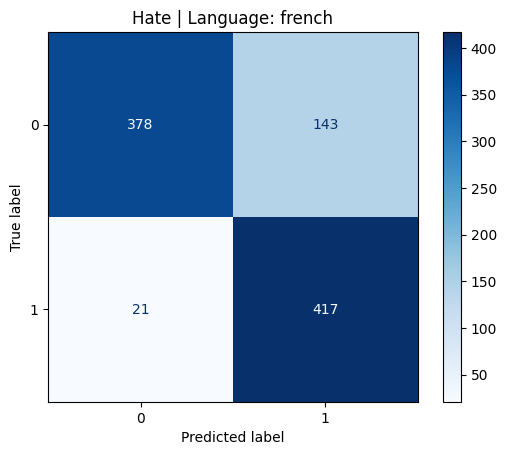

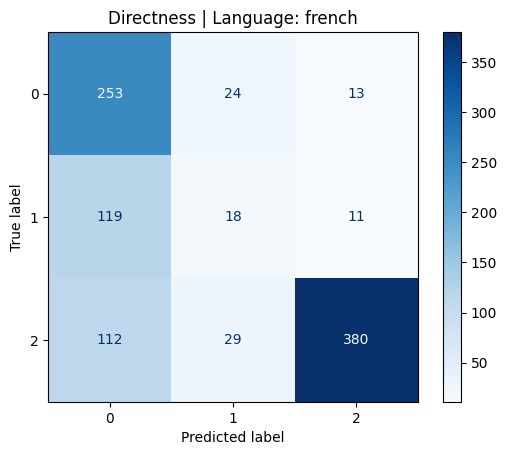

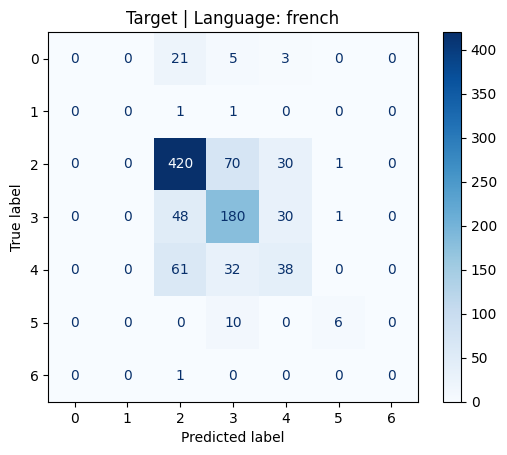

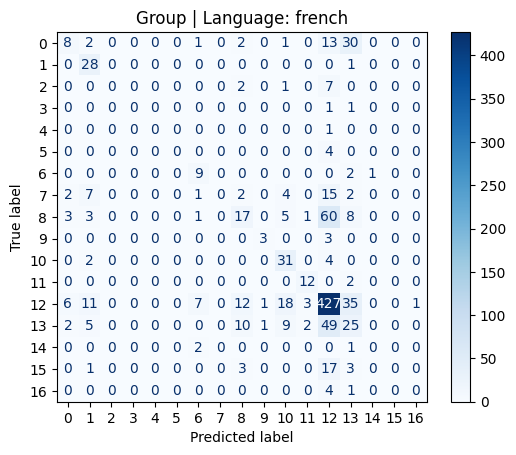


📘 Language: arabic (encoded: 2)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


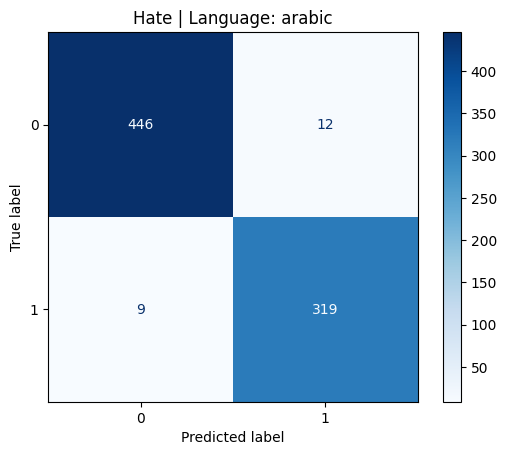

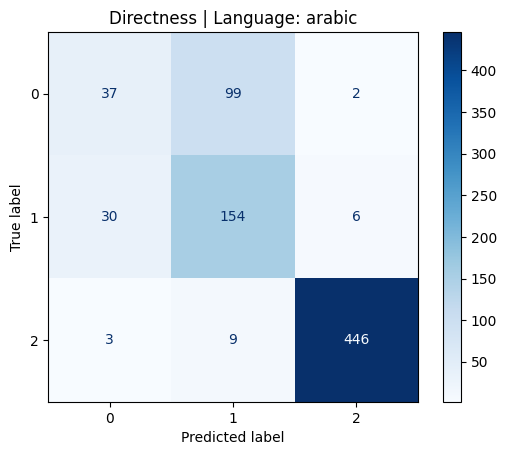

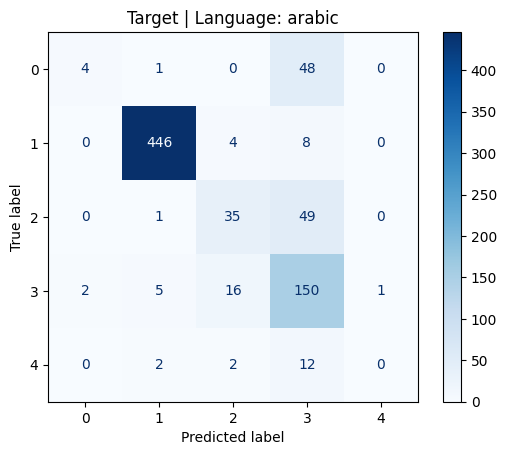

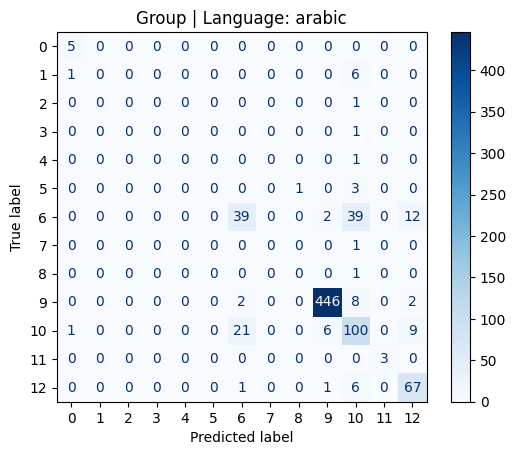


📘 Language: english (encoded: 0)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


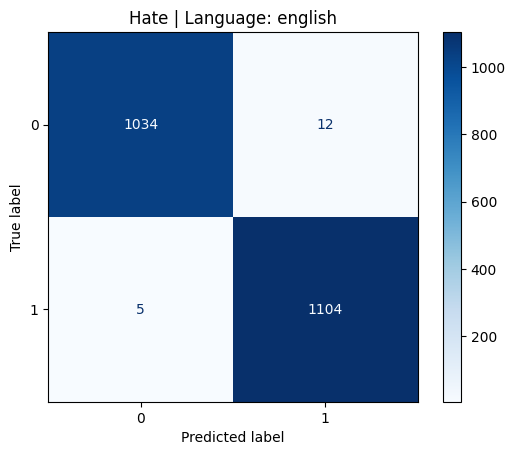

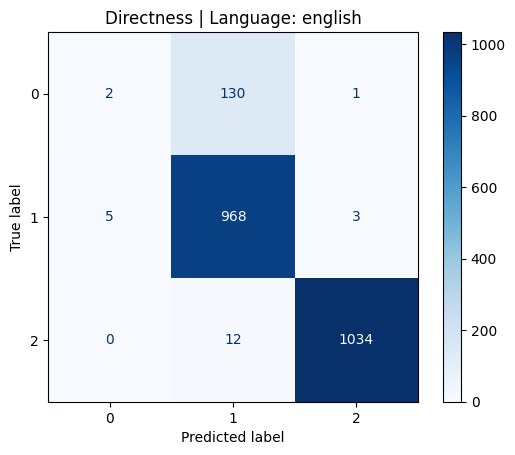

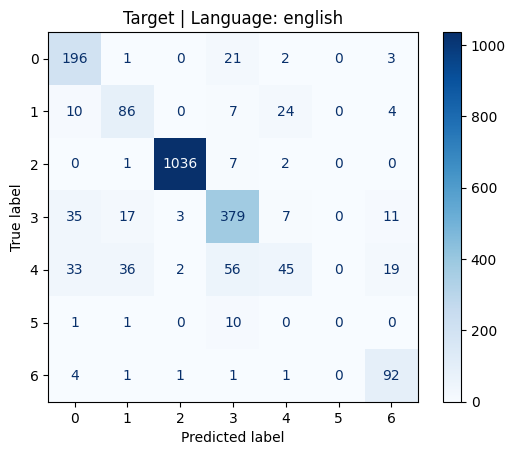

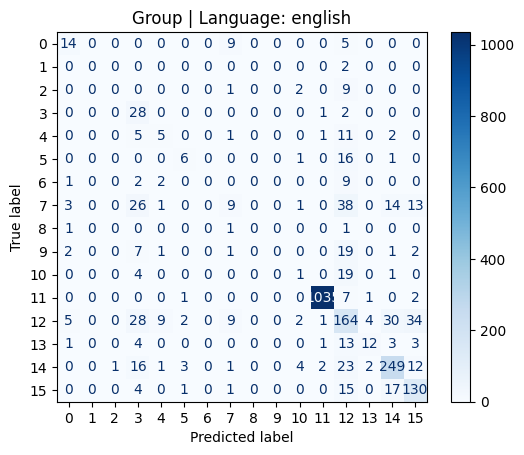

In [40]:
task_names = {
    'hate': ['Not Hate', 'Hate'],
    'directness': ['0', '1', '2'],
    'target': ["disability", "gender", "normal", "origin", "other", "religion", "sexual_orientation"],
    'group': ["african_descent", "arabs", "asians", "christian", "gay", "hispanics", "immigrants",
              "indian/hindu", "individual", "jews", "left_wing_people", "muslims", "normal", "other",
              "refugees", "special_needs", "women"],
    'sentiments': [col.replace('sentiment_', '') for col in sentiment_cols]
}


generate_confusion_matrices_by_language(model, val_df, tokenizer, device)

In [41]:
train_df.head()

,text_cleaned,language,directness_label,target_label,group_label,hatespeech,hatespeech.1,directness_label.1,target_label.1,group_label.1,sentiment_anger,sentiment_confusion,sentiment_disgust,sentiment_fear,sentiment_indifference,sentiment_normal,sentiment_sadness,sentiment_shock,language_encoded
0,يلعن شرفك يا حكم!!!,arabic,2,2,12,0,0,2,2,12,0,0,0,0,0,1,0,0,2
1,RT @J23app: Feb 2015 Jordan 4 Retro Remastered...,english,2,2,12,0,0,2,2,12,0,0,0,0,0,1,0,0,0
2,Blague : Mec : Je vais me laisser pousser la m...,french,2,2,12,0,0,2,2,12,0,0,0,0,0,1,0,0,1
3,I just put down a pan of brownies,english,2,2,12,0,0,2,2,12,0,0,0,0,0,1,0,0,0
4,في بني آدم عنده عقل بنزل مادة مقدمة في علم الم...,arabic,2,2,12,0,0,2,2,12,0,0,0,0,0,1,0,0,2


In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader

def generate_confusion_matrices_by_language(model, df, tokenizer, device,  batch_size=8):
    model.eval()
    model.to(device)

    # Class label mappings
    class_names = {
        'hate': ['Not Hate', 'Hate'],
        'directness': ['0', '1', '2'],
        'target': ["disability", "gender", "normal", "origin", "other", "religion", "sexual_orientation"],
        'group': ["african_descent", "arabs", "asians", "christian", "gay", "hispanics", "immigrants",
                  "indian/hindu", "individual", "jews", "left_wing_people", "muslims", "normal", "other",
                  "refugees", "special_needs", "women"],
        'sentiments': ['sentiment_anger','sentiment_confusion','sentiment_disgust','sentiment_fear','sentiment_indifference','sentiment_normal','sentiment_sadness','sentiment_shock']
    }

    language_map = {
        enc: lang for enc, lang in df[['language_encoded', 'language']].drop_duplicates().values
    }

    languages = df['language_encoded'].unique()

    for lang_code in languages:
        lang_name = language_map.get(lang_code, f"lang_{lang_code}")
        print(f"\n📘 Language: {lang_name} (encoded: {lang_code})")

        lang_df = df[df['language_encoded'] == lang_code]

        if len(lang_df) == 0:
            print(f"⚠️ No data for language {lang_name}. Skipping...")
            continue

        dataset = HierarchicalDataset(lang_df, tokenizer)
        loader = DataLoader(dataset, batch_size=batch_size)

        all_true = {k: [] for k in ['hate', 'directness', 'target', 'group', 'sentiments']}
        all_preds = {k: [] for k in ['hate', 'directness', 'target', 'group', 'sentiments']}

        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])

            if 'hate' in outputs:
                true_hate = batch['hate'].detach().cpu().numpy()
                pred_hate = (torch.sigmoid(outputs['hate']).detach().cpu().numpy() > 0.5).astype(int)
                all_true['hate'].extend(true_hate)
                all_preds['hate'].extend(pred_hate)

            for task in ['directness', 'target', 'group']:
                if task in outputs:
                    true_task = batch[task].detach().cpu().numpy()
                    pred_task = torch.argmax(outputs[task], dim=1).detach().cpu().numpy()
                    all_true[task].extend(true_task)
                    all_preds[task].extend(pred_task)

            if 'sentiments' in outputs:
                true_sent = batch['sentiments'].detach().cpu().numpy()
                pred_sent = (torch.sigmoid(outputs['sentiments']).detach().cpu().numpy() > 0.5).astype(int)
                all_true['sentiments'].extend(true_sent)
                all_preds['sentiments'].extend(pred_sent)

        # Plot confusion matrices for single-label tasks
        for task in ['hate', 'directness', 'target', 'group']:
            if len(all_true[task]) == 0 or len(all_preds[task]) == 0:
                print(f"⚠️ Skipping {task} for language {lang_name} due to no data.")
                continue
            cm = confusion_matrix(all_true[task], all_preds[task], labels=list(range(len(class_names[task]))))
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names[task])
            disp.plot(cmap='Blues', xticks_rotation=45)
            plt.title(f'{task.capitalize()} | Language: {lang_name}')
            plt.tight_layout()
            plt.show()

        # Multi-label confusion matrix for sentiments
        if len(all_true['sentiments']) > 0 and len(all_preds['sentiments']) > 0:
            # true_sent_arr = np.array(all_true['sentiments'])
            # pred_sent_arr = np.array(all_preds['sentiments'])

            # if true_sent_arr.shape != pred_sent_arr.shape:
            #     print(f"⚠️ Sentiment shape mismatch for language {lang_name}. Skipping sentiment confusion matrices.")
            #     continue
            true_sent_arr = np.vstack(all_true['sentiments'])  # ensures shape [N, 8]
            pred_sent_arr = np.vstack(all_preds['sentiments'])  # same

            if true_sent_arr.shape != pred_sent_arr.shape:
                print(f"⚠️ Sentiment shape mismatch for language {lang_name}. Got {true_sent_arr.shape} vs {pred_sent_arr.shape}. Skipping sentiment confusion matrices.")
                continue


            for i, label in enumerate(class_names['sentiments']):
                cm = confusion_matrix(true_sent_arr[:, i], pred_sent_arr[:, i], labels=[0, 1])
                plt.figure(figsize=(12, 8))
                disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
                disp.plot(cmap='Purples',ax=plt.gca(), xticks_rotation=45)
                plt.title(f'Sentiment: {label} | Language: {lang_name}')
                plt.xticks(rotation=45, ha="right")
                #plt.tight_layout()
                plt.show()
        else:
            print(f"⚠️ Skipping sentiments for language {lang_name} due to no data.")



📘 Language: french (encoded: 1)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


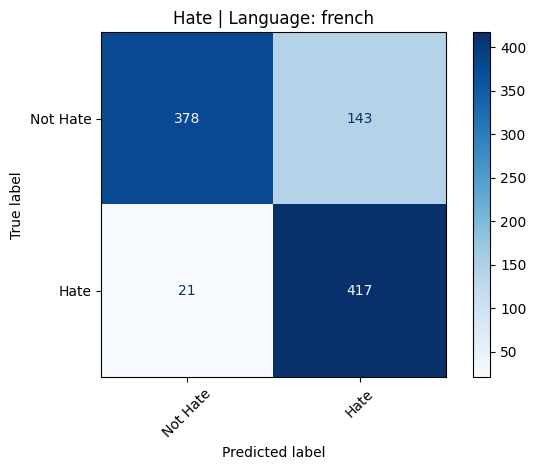

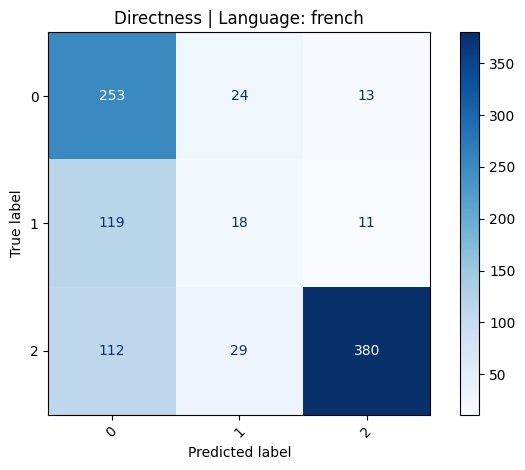

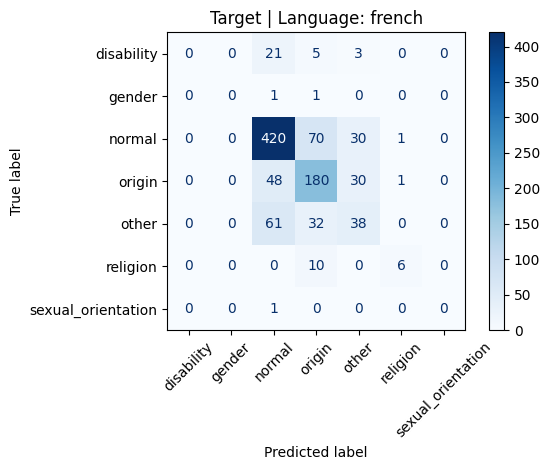

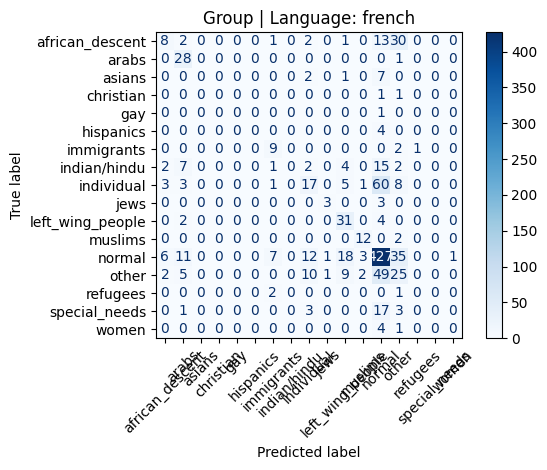

⚠️ Sentiment shape mismatch for language french. Got (959, 0) vs (959, 8). Skipping sentiment confusion matrices.

📘 Language: arabic (encoded: 2)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


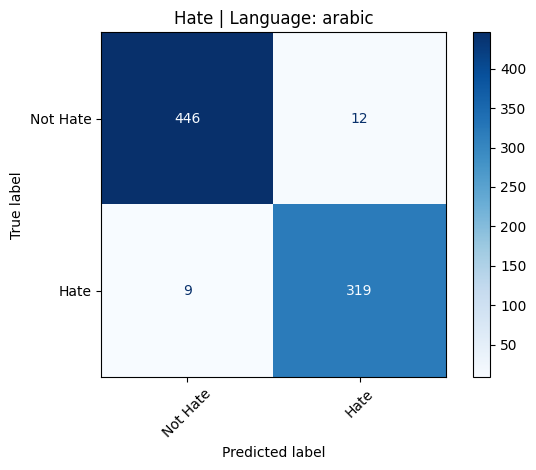

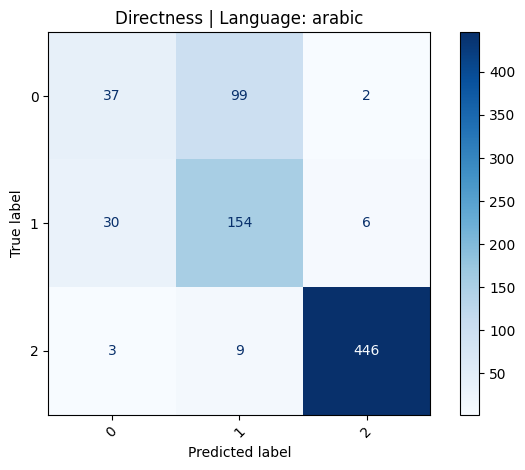

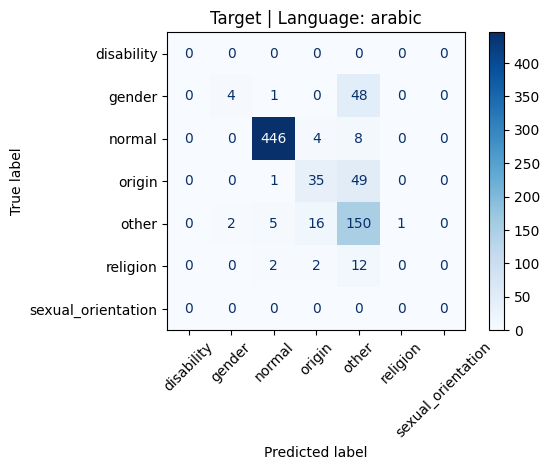

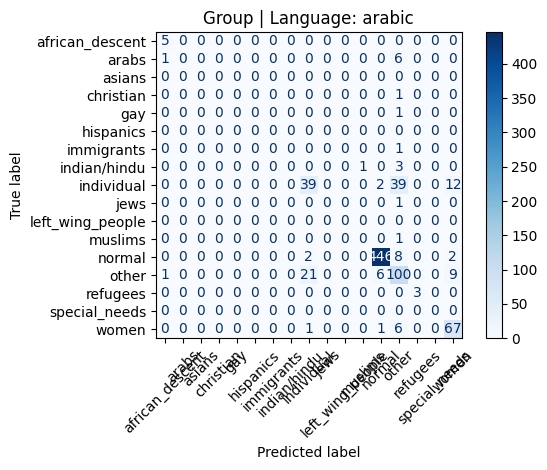

⚠️ Sentiment shape mismatch for language arabic. Got (786, 0) vs (786, 8). Skipping sentiment confusion matrices.

📘 Language: english (encoded: 0)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


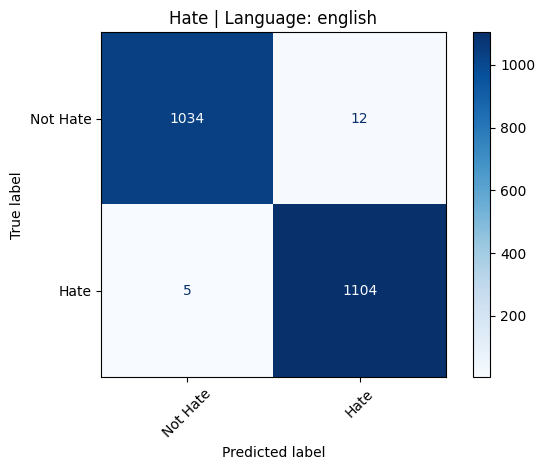

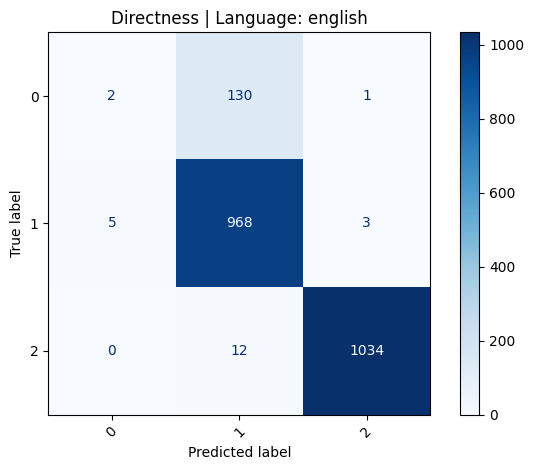

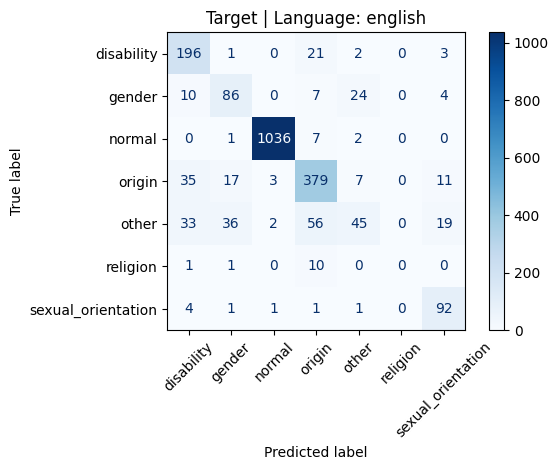

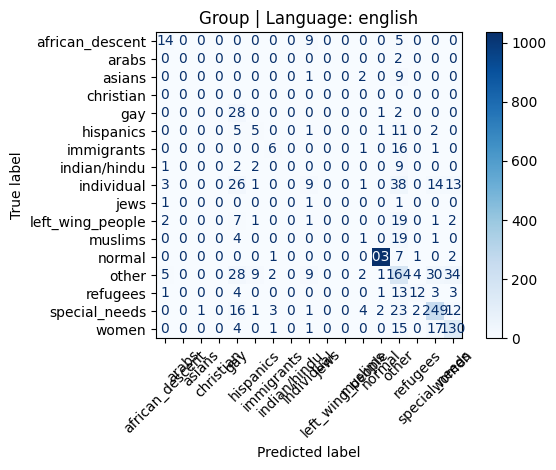

⚠️ Sentiment shape mismatch for language english. Got (2155, 0) vs (2155, 8). Skipping sentiment confusion matrices.


In [58]:
generate_confusion_matrices_by_language(model, val_df, tokenizer, device)

In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader

def generate_confusion_matrices_by_language(model, df, tokenizer, device,  batch_size=8):
    model.eval()
    model.to(device)

    # Class label mappings
    class_names = {
        'hate': ['Not Hate', 'Hate'],
        'directness': ['0', '1', '2'],
        'target': ["disability", "gender", "normal", "origin", "other", "religion", "sexual_orientation"],
        'group': ["african_descent", "arabs", "asians", "christian", "gay", "hispanics", "immigrants",
                  "indian/hindu", "individual", "jews", "left_wing_people", "muslims", "normal", "other",
                  "refugees", "special_needs", "women"],
        'sentiments': ['sentiment_anger','sentiment_confusion','sentiment_disgust','sentiment_fear','sentiment_indifference','sentiment_normal','sentiment_sadness','sentiment_shock']
    }

    language_map = {
        enc: lang for enc, lang in df[['language_encoded', 'language']].drop_duplicates().values
    }

    languages = df['language_encoded'].unique()

    for language_code in val_df['language'].unique():
        lang_name = language_map.get(language_code, f"lang_{language_code}")
        lang_df = val_df[val_df['language'] == language_code]

        # 🎯 Make sure sentiment labels exist for this language
        sentiment_values = lang_df[sentiment_cols].values
        if sentiment_values.shape[0] == 0 or sentiment_values.shape[1] == 0:
            print(f"🚨 Sentiment shape mismatch for language {language_code}. Skipping sentiment confusion matrices.")
            continue
        print(f"Checking sentiments for language {language_code}:")
        print(f"Shape before slicing: {val_df.shape}")
        print(f"Columns: {val_df.columns.tolist()}")
        print(f"Shape of lang_df: {lang_df.shape}")
        print(f"Columns in lang_df: {lang_df.columns.tolist()}")
        print(f"Sentiment columns in lang_df: {[col for col in lang_df.columns if col.startswith('sentiment_')]}")


        dataset = HierarchicalDataset(lang_df, tokenizer)
        loader = DataLoader(dataset, batch_size=batch_size)

        all_true = {k: [] for k in ['hate', 'directness', 'target', 'group', 'sentiments']}
        all_preds = {k: [] for k in ['hate', 'directness', 'target', 'group', 'sentiments']}

        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])

            if 'hate' in outputs:
                true_hate = batch['hate'].detach().cpu().numpy()
                pred_hate = (torch.sigmoid(outputs['hate']).detach().cpu().numpy() > 0.5).astype(int)
                all_true['hate'].extend(true_hate)
                all_preds['hate'].extend(pred_hate)

            for task in ['directness', 'target', 'group']:
                if task in outputs:
                    true_task = batch[task].detach().cpu().numpy()
                    pred_task = torch.argmax(outputs[task], dim=1).detach().cpu().numpy()
                    all_true[task].extend(true_task)
                    all_preds[task].extend(pred_task)

            if 'sentiments' in outputs:
                true_sent = batch['sentiments'].detach().cpu().numpy()
                pred_sent = (torch.sigmoid(outputs['sentiments']).detach().cpu().numpy() > 0.5).astype(int)
                all_true['sentiments'].extend(true_sent)
                all_preds['sentiments'].extend(pred_sent)

        # Plot confusion matrices for single-label tasks
        for task in ['hate', 'directness', 'target', 'group']:
            if len(all_true[task]) == 0 or len(all_preds[task]) == 0:
                print(f"⚠️ Skipping {task} for language {lang_name} due to no data.")
                continue
            cm = confusion_matrix(all_true[task], all_preds[task], labels=list(range(len(class_names[task]))))
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names[task])
            disp.plot(cmap='Blues', xticks_rotation=45)
            plt.title(f'{task.capitalize()} | Language: {lang_name}')
            plt.tight_layout()
            plt.show()

        # Multi-label confusion matrix for sentiments
        if len(all_true['sentiments']) > 0 and len(all_preds['sentiments']) > 0:
            # true_sent_arr = np.array(all_true['sentiments'])
            # pred_sent_arr = np.array(all_preds['sentiments'])

            # if true_sent_arr.shape != pred_sent_arr.shape:
            #     print(f"⚠️ Sentiment shape mismatch for language {lang_name}. Skipping sentiment confusion matrices.")
            #     continue
            true_sent_arr = np.vstack(all_true['sentiments'])  # ensures shape [N, 8]
            pred_sent_arr = np.vstack(all_preds['sentiments'])  # same

            if true_sent_arr.shape != pred_sent_arr.shape:
                print(f"⚠️ Sentiment shape mismatch for language {lang_name}. Got {true_sent_arr.shape} vs {pred_sent_arr.shape}. Skipping sentiment confusion matrices.")
                continue


            for i, label in enumerate(class_names['sentiments']):
                cm = confusion_matrix(true_sent_arr[:, i], pred_sent_arr[:, i], labels=[0, 1])
                plt.figure(figsize=(12, 8))
                disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
                disp.plot(cmap='Purples',ax=plt.gca(), xticks_rotation=45)
                plt.title(f'Sentiment: {label} | Language: {lang_name}')
                plt.xticks(rotation=45, ha="right")
                #plt.tight_layout()
                plt.show()
        else:
            print(f"⚠️ Skipping sentiments for language {lang_name} due to no data.")

Checking sentiments for language french:
Shape before slicing: (3900, 19)
Columns: ['text_cleaned', 'language', 'directness_label', 'target_label', 'group_label', 'hatespeech', 'hatespeech.1', 'directness_label.1', 'target_label.1', 'group_label.1', 'sentiment_anger', 'sentiment_confusion', 'sentiment_disgust', 'sentiment_fear', 'sentiment_indifference', 'sentiment_normal', 'sentiment_sadness', 'sentiment_shock', 'language_encoded']
Shape of lang_df: (959, 19)
Columns in lang_df: ['text_cleaned', 'language', 'directness_label', 'target_label', 'group_label', 'hatespeech', 'hatespeech.1', 'directness_label.1', 'target_label.1', 'group_label.1', 'sentiment_anger', 'sentiment_confusion', 'sentiment_disgust', 'sentiment_fear', 'sentiment_indifference', 'sentiment_normal', 'sentiment_sadness', 'sentiment_shock', 'language_encoded']
Sentiment columns in lang_df: ['sentiment_anger', 'sentiment_confusion', 'sentiment_disgust', 'sentiment_fear', 'sentiment_indifference', 'sentiment_normal', 'se

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


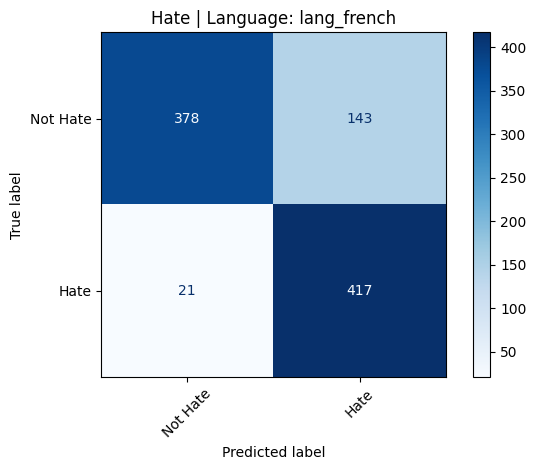

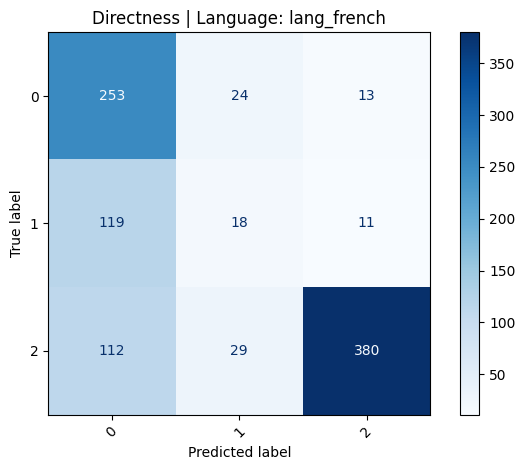

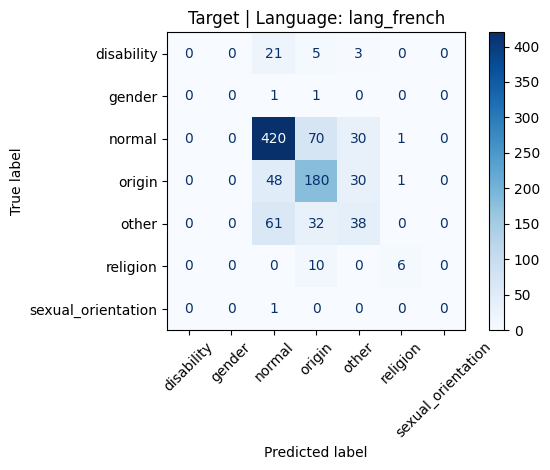

KeyboardInterrupt: 

In [75]:
generate_confusion_matrices_by_language(model, val_df, tokenizer, device)